In [1]:
import re
import sys
from time import sleep
from pprint import pprint
from functools import partial

import numpy as np
import optuna
try:
    import pandas as pd
except:
    pass


FILENAME = "main.cpp"

In [3]:
#!cp ../exp012_Dlarge_M2/main.cpp ./

In [4]:
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out

main.cpp:458: warning: ignoring #pragma warning  [-Wunknown-pragmas]
  458 | #pragma warning( disable : 4146 )
      | 
main.cpp: In member function ‘void UltimateEstimator::Step()’:
main.cpp:1149:39: warning: comparison of integer expressions of different signedness: ‘signed char’ and ‘std::array<double, 60>::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
 1149 |   for (auto col = (signed char)0; col < data_x.size(); col++) {
      |                                   ~~~~^~~~~~~~~~~~~~~
main.cpp:1107:8: warning: unused variable ‘estimated_distance’ [-Wunused-variable]
 1107 |   auto estimated_distance = 0.0;
      |        ^~~~~~~~~~~~~~~~~~
main.cpp: In member function ‘void Explorer::Step()’:
main.cpp:1465:30: warning: narrowing conversion of ‘(((int)v.Explorer::Node::y) + 1)’ from ‘int’ to ‘signed char’ [-Wnarrowing]
 1465 |     const auto u = Node{ v.y + (i8)1, v.x, false };
      |                          ~~~~^~~~~~~
main.cpp:1478:35: warning: narrowing conversion of ‘(((

In [5]:
%%time
# もとのスコアの確認
scores = []
for i in range(200):
    i = f"{i:03d}"
    score = !cargo run --release --manifest-path ../tools/Cargo.toml --bin tester in/{i}.txt $(pwd)/{FILENAME}.out 2>&1 | grep Score
    print(i, *score)
    score = int(score[0].split()[-1])
    scores.append(score)
np.mean(scores) / 1e6, np.std(scores) / 1e6

000 Score = 963794187
001 Score = 955409036
002 Score = 972722340
003 Score = 971951113
004 Score = 966439526
005 Score = 969304372
006 Score = 964060037
007 Score = 964579066
008 Score = 965178566
009 Score = 970005736
010 Score = 969608992
011 Score = 964608956
012 Score = 965499182
013 Score = 971105749
014 Score = 946858655
015 Score = 973883072
016 Score = 966984997
017 Score = 961520656
018 Score = 958489016
019 Score = 966106561
020 Score = 963146225
021 Score = 957966532
022 Score = 948535176
023 Score = 958281871
024 Score = 965374983
025 Score = 959359846
026 Score = 960149607
027 Score = 964344967
028 Score = 964720892
029 Score = 961220643
030 Score = 963863446
031 Score = 966127567
032 Score = 960780328
033 Score = 973137707
034 Score = 958631000
035 Score = 952166802
036 Score = 962916044
037 Score = 937894260
038 Score = 971650701
039 Score = 954029659
040 Score = 961609677
041 Score = 958898550
042 Score = 942647984
043 Score = 972568192
044 Score = 958430370
045 Score 

(961.494331055, 7.329142407408539)

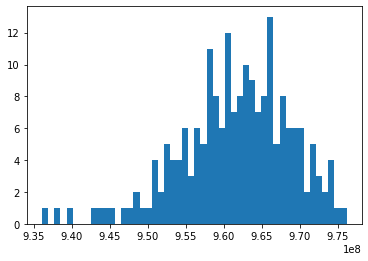

In [6]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.show()

In [2]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

3 variables were found.


,name,method,min,max,log,left,right
0,LAMBDA,suggest_float,2.0,10000.0,True,constexpr double LAMBDA =,"; // OPTIMIZE [2.0, 1e4] LOG"
1,LASSO_LAMBDA,suggest_float,1000.0,1000000.0,True,constexpr double LASSO_LAMBDA =,"; // OPTIMIZE [1e3, 1e6] LOG"
2,RIDGE2_LAMBDA,suggest_float,1.0,10000000.0,True,constexpr double RIDGE2_LAMBDA =,"; // OPTIMIZE [1.0, 1e7] LOG"


In [3]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 10  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out
    !mkdir {index_parallel}_score
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {directory_input}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read())
    return sum_score

In [4]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 10
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=2, callbacks=[callback])

[I 2021-05-30 02:26:54,966] Using an existing study with name 'study' instead of creating a new one.
/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


index_parallel=8
index_parallel=9
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 38.430818097480184;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20772.710643781054;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1498.957051319375;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/con

[I 2021-05-30 02:28:32,813] Trial 259 finished with value: 192272644343.0 and parameters: {'LAMBDA': 42.420985814586096, 'LASSO_LAMBDA': 20638.598983122265, 'RIDGE2_LAMBDA': 1408.7070604804926}. Best is trial 213 with value: 192388724338.0.
[I 2021-05-30 02:28:32,851] Trial 258 finished with value: 192227313825.0 and parameters: {'LAMBDA': 38.430818097480184, 'LASSO_LAMBDA': 20772.710643781054, 'RIDGE2_LAMBDA': 1498.957051319375}. Best is trial 213 with value: 192388724338.0.


callback ok
callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.20703547600261;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17458.031767531273;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 932.9225441681923;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE

[I 2021-05-30 02:30:27,964] Trial 261 finished with value: 192359749344.0 and parameters: {'LAMBDA': 47.52136187192507, 'LASSO_LAMBDA': 17197.337627225636, 'RIDGE2_LAMBDA': 1001.1202114865204}. Best is trial 213 with value: 192388724338.0.
[I 2021-05-30 02:30:27,975] Trial 260 finished with value: 192344483540.0 and parameters: {'LAMBDA': 46.20703547600261, 'LASSO_LAMBDA': 17458.031767531273, 'RIDGE2_LAMBDA': 932.9225441681923}. Best is trial 213 with value: 192388724338.0.


callback ok
callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.419645015889486;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 24481.34861395014;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 342.40417917380825;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 02:32:06,209] Trial 263 finished with value: 192257966390.0 and parameters: {'LAMBDA': 49.48315873695541, 'LASSO_LAMBDA': 24350.74760647899, 'RIDGE2_LAMBDA': 310.9218164718336}. Best is trial 213 with value: 192388724338.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists


[I 2021-05-30 02:32:06,323] Trial 262 finished with value: 192270155218.0 and parameters: {'LAMBDA': 50.419645015889486, 'LASSO_LAMBDA': 24481.34861395014, 'RIDGE2_LAMBDA': 342.40417917380825}. Best is trial 213 with value: 192388724338.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.12198626130313;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14039.847349259077;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1815.1832200017875;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 64.51264713846778;           \/\/ 

[I 2021-05-30 02:33:46,406] Trial 265 finished with value: 192172411085.0 and parameters: {'LAMBDA': 64.51264713846778, 'LASSO_LAMBDA': 13320.971791029187, 'RIDGE2_LAMBDA': 132.93331690406293}. Best is trial 213 with value: 192388724338.0.


callback ok


[I 2021-05-30 02:33:46,495] Trial 264 finished with value: 192189452803.0 and parameters: {'LAMBDA': 63.12198626130313, 'LASSO_LAMBDA': 14039.847349259077, 'RIDGE2_LAMBDA': 1815.1832200017875}. Best is trial 213 with value: 192388724338.0.


index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.9111536929011;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17918.92981755957;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 924.0532600067917;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\]

[I 2021-05-30 02:35:31,170] Trial 267 finished with value: 192333260530.0 and parameters: {'LAMBDA': 44.85972415836913, 'LASSO_LAMBDA': 17249.404530649972, 'RIDGE2_LAMBDA': 961.4820137540147}. Best is trial 213 with value: 192388724338.0.
[I 2021-05-30 02:35:31,193] Trial 266 finished with value: 192351970308.0 and parameters: {'LAMBDA': 43.9111536929011, 'LASSO_LAMBDA': 17918.92981755957, 'RIDGE2_LAMBDA': 924.0532600067917}. Best is trial 213 with value: 192388724338.0.


callback ok
callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.40073784214925;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10860.31595755785;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 956.8727396967959;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE 

[I 2021-05-30 02:37:13,018] Trial 269 finished with value: 192395907587.0 and parameters: {'LAMBDA': 42.99157066434686, 'LASSO_LAMBDA': 16887.647897090108, 'RIDGE2_LAMBDA': 993.1341703870245}. Best is trial 269 with value: 192395907587.0.


Updated! 192395907587.0
callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists


[I 2021-05-30 02:37:13,237] Trial 268 finished with value: 192022606851.0 and parameters: {'LAMBDA': 44.40073784214925, 'LASSO_LAMBDA': 10860.31595755785, 'RIDGE2_LAMBDA': 956.8727396967959}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.85762619568647;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16651.290397012148;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1106.5371109231294;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 30.216477775145545;           \/\/

[I 2021-05-30 02:38:52,089] Trial 271 finished with value: 192250565497.0 and parameters: {'LAMBDA': 30.216477775145545, 'LASSO_LAMBDA': 16062.131822056326, 'RIDGE2_LAMBDA': 1206.463771479387}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists


[I 2021-05-30 02:38:52,202] Trial 270 finished with value: 192277345693.0 and parameters: {'LAMBDA': 31.85762619568647, 'LASSO_LAMBDA': 16651.290397012148, 'RIDGE2_LAMBDA': 1106.5371109231294}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 41.44440224460318;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12064.485072134394;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 531.3121189623387;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.18051069478163;           \/\/ O

[I 2021-05-30 02:40:31,570] Trial 273 finished with value: 192161957012.0 and parameters: {'LAMBDA': 40.18051069478163, 'LASSO_LAMBDA': 12043.870018173911, 'RIDGE2_LAMBDA': 1584.331806523012}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:40:31,575] Trial 272 finished with value: 192065455620.0 and parameters: {'LAMBDA': 41.44440224460318, 'LASSO_LAMBDA': 12064.485072134394, 'RIDGE2_LAMBDA': 531.3121189623387}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=4
index_parallel=5
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.659000569553825;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14984.768401925878;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 867.0315284090229;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 02:42:09,674] Trial 274 finished with value: 192260153462.0 and parameters: {'LAMBDA': 33.659000569553825, 'LASSO_LAMBDA': 14984.768401925878, 'RIDGE2_LAMBDA': 867.0315284090229}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:42:09,698] Trial 275 finished with value: 192222018463.0 and parameters: {'LAMBDA': 34.13840348531157, 'LASSO_LAMBDA': 14327.035946083994, 'RIDGE2_LAMBDA': 35.912400597626075}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.31457009421377;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17672.93726613047;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1756.4338010328518;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE

[I 2021-05-30 02:43:47,716] Trial 276 finished with value: 192335702536.0 and parameters: {'LAMBDA': 44.31457009421377, 'LASSO_LAMBDA': 17672.93726613047, 'RIDGE2_LAMBDA': 1756.4338010328518}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:43:47,740] Trial 277 finished with value: 192290559254.0 and parameters: {'LAMBDA': 43.00240481842281, 'LASSO_LAMBDA': 18141.120999436174, 'RIDGE2_LAMBDA': 1980.0589581293832}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 24.7778326733357;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17167.309443921466;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1642.1931634795976;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE

[I 2021-05-30 02:45:26,011] Trial 279 finished with value: 192216048114.0 and parameters: {'LAMBDA': 25.21598614431043, 'LASSO_LAMBDA': 16686.77068084563, 'RIDGE2_LAMBDA': 1538.4490057034488}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists


[I 2021-05-30 02:45:26,110] Trial 278 finished with value: 192148600495.0 and parameters: {'LAMBDA': 24.7778326733357, 'LASSO_LAMBDA': 17167.309443921466, 'RIDGE2_LAMBDA': 1642.1931634795976}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 57.13976605505457;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14616.356092173466;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 569.6255324080304;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 38.18023978373441;           \/\/ O

[I 2021-05-30 02:47:03,850] Trial 281 finished with value: 192205293659.0 and parameters: {'LAMBDA': 38.18023978373441, 'LASSO_LAMBDA': 13897.282621346976, 'RIDGE2_LAMBDA': 1232.8419017950482}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:47:03,862] Trial 280 finished with value: 192228852680.0 and parameters: {'LAMBDA': 57.13976605505457, 'LASSO_LAMBDA': 14616.356092173466, 'RIDGE2_LAMBDA': 569.6255324080304}. Best is trial 269 with value: 192395907587.0.


callback okcallback ok

index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.618382654341836;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22075.574299857304;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2149.1157692616857;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMI

[I 2021-05-30 02:48:40,288] Trial 283 finished with value: 192240101985.0 and parameters: {'LAMBDA': 44.519583919930255, 'LASSO_LAMBDA': 22357.26748942885, 'RIDGE2_LAMBDA': 2029.3306719388677}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists


[I 2021-05-30 02:48:40,429] Trial 282 finished with value: 192255365125.0 and parameters: {'LAMBDA': 40.618382654341836, 'LASSO_LAMBDA': 22075.574299857304, 'RIDGE2_LAMBDA': 2149.1157692616857}. Best is trial 269 with value: 192395907587.0.


callback ok
mkdir: cannot create directory ‘4_score’: File exists
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
rm: cannot remove '4_out/*': No such file or directory
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.97073155042951;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17860.377559620734;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 165.0112598605402;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[

[I 2021-05-30 02:50:19,080] Trial 285 finished with value: 192208258628.0 and parameters: {'LAMBDA': 31.407635597657094, 'LASSO_LAMBDA': 17815.131628717736, 'RIDGE2_LAMBDA': 940.6024959941968}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:50:19,097] Trial 284 finished with value: 192302547911.0 and parameters: {'LAMBDA': 31.97073155042951, 'LASSO_LAMBDA': 17860.377559620734, 'RIDGE2_LAMBDA': 165.0112598605402}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 59.2155361876757;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10293.71367691429;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 675.9895154504034;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \

[I 2021-05-30 02:51:58,277] Trial 286 finished with value: 191958377056.0 and parameters: {'LAMBDA': 59.2155361876757, 'LASSO_LAMBDA': 10293.71367691429, 'RIDGE2_LAMBDA': 675.9895154504034}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:51:58,285] Trial 287 finished with value: 192231376859.0 and parameters: {'LAMBDA': 55.12356664766293, 'LASSO_LAMBDA': 13282.233747950344, 'RIDGE2_LAMBDA': 650.3275418566765}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=8
index_parallel=9
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.77170293672472;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15684.721949649484;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1336.0318597132066;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 02:53:37,034] Trial 289 finished with value: 192268812994.0 and parameters: {'LAMBDA': 46.604545357418516, 'LASSO_LAMBDA': 15379.939646078408, 'RIDGE2_LAMBDA': 1217.2254686671624}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:53:37,066] Trial 288 finished with value: 192270684040.0 and parameters: {'LAMBDA': 71.77170293672472, 'LASSO_LAMBDA': 15684.721949649484, 'RIDGE2_LAMBDA': 1336.0318597132066}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.07139650897701;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 26744.758967423302;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 507.493200816026;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE 

[I 2021-05-30 02:55:14,397] Trial 290 finished with value: 192189333043.0 and parameters: {'LAMBDA': 39.07139650897701, 'LASSO_LAMBDA': 26744.758967423302, 'RIDGE2_LAMBDA': 507.493200816026}. Best is trial 269 with value: 192395907587.0.


callback ok


[I 2021-05-30 02:55:14,440] Trial 291 finished with value: 192181633972.0 and parameters: {'LAMBDA': 37.2428988352386, 'LASSO_LAMBDA': 26451.529924015358, 'RIDGE2_LAMBDA': 459.95551453608834}. Best is trial 269 with value: 192395907587.0.


index_parallel=2
callback ok
mkdir: cannot create directory ‘2_out’: File exists
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 47.39882432727547;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19336.06197006807;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 934.4039898283423;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\

[I 2021-05-30 02:56:52,981] Trial 292 finished with value: 192334482634.0 and parameters: {'LAMBDA': 47.39882432727547, 'LASSO_LAMBDA': 19336.06197006807, 'RIDGE2_LAMBDA': 934.4039898283423}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists


[I 2021-05-30 02:56:53,095] Trial 293 finished with value: 192356388820.0 and parameters: {'LAMBDA': 47.86781389798343, 'LASSO_LAMBDA': 19376.478637822252, 'RIDGE2_LAMBDA': 1578.0895844193046}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.96263680643319;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19683.95045388343;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1040.714253896739;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.55163029825345;           \/\/ OP

[I 2021-05-30 02:58:30,790] Trial 295 finished with value: 192325468368.0 and parameters: {'LAMBDA': 50.55163029825345, 'LASSO_LAMBDA': 19825.5479378351, 'RIDGE2_LAMBDA': 1010.9197751676493}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 02:58:30,797] Trial 294 finished with value: 192319826335.0 and parameters: {'LAMBDA': 50.96263680643319, 'LASSO_LAMBDA': 19683.95045388343, 'RIDGE2_LAMBDA': 1040.714253896739}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 70.23599645613426;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21328.95327821135;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1763.6510745331802;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE

[I 2021-05-30 03:00:09,319] Trial 297 finished with value: 192231075412.0 and parameters: {'LAMBDA': 62.30788024875108, 'LASSO_LAMBDA': 21788.75662834698, 'RIDGE2_LAMBDA': 1675.3695464476878}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 03:00:09,336] Trial 296 finished with value: 192234697430.0 and parameters: {'LAMBDA': 70.23599645613426, 'LASSO_LAMBDA': 21328.95327821135, 'RIDGE2_LAMBDA': 1763.6510745331802}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 924.1900716368887;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18809.465554991664;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 906.4496837831854;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE

[I 2021-05-30 03:01:47,562] Trial 299 finished with value: 192310195975.0 and parameters: {'LAMBDA': 51.74536930169793, 'LASSO_LAMBDA': 18951.261940352637, 'RIDGE2_LAMBDA': 2705.110210317528}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 03:01:47,583] Trial 298 finished with value: 192251079719.0 and parameters: {'LAMBDA': 924.1900716368887, 'LASSO_LAMBDA': 18809.465554991664, 'RIDGE2_LAMBDA': 906.4496837831854}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=0
index_parallel=1
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 57.818719633345495;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13906.976649009377;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1253.3108144624098;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMI

[I 2021-05-30 03:03:26,211] Trial 301 finished with value: 192212885431.0 and parameters: {'LAMBDA': 57.818719633345495, 'LASSO_LAMBDA': 13906.976649009377, 'RIDGE2_LAMBDA': 1253.3108144624098}. Best is trial 269 with value: 192395907587.0.
[I 2021-05-30 03:03:26,222] Trial 300 finished with value: 192197309519.0 and parameters: {'LAMBDA': 55.186578264785, 'LASSO_LAMBDA': 13066.127026984064, 'RIDGE2_LAMBDA': 1275.9303236138242}. Best is trial 269 with value: 192395907587.0.


callback ok
callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 45.474737989589705;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23481.05349447693;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2189.0938113319457;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 03:05:04,025] Trial 303 finished with value: 192256061981.0 and parameters: {'LAMBDA': 45.474737989589705, 'LASSO_LAMBDA': 23481.05349447693, 'RIDGE2_LAMBDA': 2189.0938113319457}. Best is trial 269 with value: 192395907587.0.


callback ok


[I 2021-05-30 03:05:04,100] Trial 302 finished with value: 192346137231.0 and parameters: {'LAMBDA': 46.521871682942574, 'LASSO_LAMBDA': 17108.961481525293, 'RIDGE2_LAMBDA': 783.7232614422733}. Best is trial 269 with value: 192395907587.0.


index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '5_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 70.52214566864095;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11380.045207612382;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 746.8983782011167;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4

[I 2021-05-30 03:06:43,800] Trial 304 finished with value: 191844608571.0 and parameters: {'LAMBDA': 70.52214566864095, 'LASSO_LAMBDA': 11380.045207612382, 'RIDGE2_LAMBDA': 746.8983782011167}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists


[I 2021-05-30 03:06:43,902] Trial 305 finished with value: 191869679059.0 and parameters: {'LAMBDA': 69.55478269064137, 'LASSO_LAMBDA': 11176.457597529123, 'RIDGE2_LAMBDA': 759.4969333775648}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '7_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 45.63446581857637;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15577.723498138292;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1660.633862245156;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.42450865948806;           \/\/ O

[I 2021-05-30 03:08:21,602] Trial 306 finished with value: 192313804408.0 and parameters: {'LAMBDA': 45.63446581857637, 'LASSO_LAMBDA': 15577.723498138292, 'RIDGE2_LAMBDA': 1660.633862245156}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists


[I 2021-05-30 03:08:21,706] Trial 307 finished with value: 192344535463.0 and parameters: {'LAMBDA': 44.42450865948806, 'LASSO_LAMBDA': 16561.65830410439, 'RIDGE2_LAMBDA': 1725.3496929926316}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '9_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 29.543797333917144;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18250.02331447185;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2373.359344527655;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 29.099760478654375;           \/\/ 

[I 2021-05-30 03:09:59,465] Trial 308 finished with value: 192216528675.0 and parameters: {'LAMBDA': 29.543797333917144, 'LASSO_LAMBDA': 18250.02331447185, 'RIDGE2_LAMBDA': 2373.359344527655}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists


[I 2021-05-30 03:09:59,613] Trial 309 finished with value: 192180980102.0 and parameters: {'LAMBDA': 29.099760478654375, 'LASSO_LAMBDA': 17792.02912716866, 'RIDGE2_LAMBDA': 2716.853903806944}. Best is trial 269 with value: 192395907587.0.


callback ok
mkdir: cannot create directory ‘0_score’: File exists
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
rm: cannot remove '0_out/*': No such file or directory
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 35.21981927812058;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 963947.3568803418;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1434.333901229394;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2

[I 2021-05-30 03:11:45,243] Trial 310 finished with value: 186052335067.0 and parameters: {'LAMBDA': 35.21981927812058, 'LASSO_LAMBDA': 963947.3568803418, 'RIDGE2_LAMBDA': 1434.333901229394}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.44965075220202;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15246.11277932513;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 962.6795303905535;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:11:47,860] Trial 311 finished with value: 192277543334.0 and parameters: {'LAMBDA': 35.36703858574616, 'LASSO_LAMBDA': 14904.339982168336, 'RIDGE2_LAMBDA': 1433.7630567547474}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.015735520326885;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12628.591356391324;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 957.4781622194774;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:13:39,972] Trial 312 finished with value: 192297961548.0 and parameters: {'LAMBDA': 42.44965075220202, 'LASSO_LAMBDA': 15246.11277932513, 'RIDGE2_LAMBDA': 962.6795303905535}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.20334693155282;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16895.949265635067;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 615.8055456172558;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:13:44,287] Trial 313 finished with value: 192167672778.0 and parameters: {'LAMBDA': 39.015735520326885, 'LASSO_LAMBDA': 12628.591356391324, 'RIDGE2_LAMBDA': 957.4781622194774}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 45.646480512099274;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17093.15857321854;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 407.89412603480406;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:15:31,115] Trial 314 finished with value: 192359487734.0 and parameters: {'LAMBDA': 43.20334693155282, 'LASSO_LAMBDA': 16895.949265635067, 'RIDGE2_LAMBDA': 615.8055456172558}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.73264775053203;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16650.183570750945;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 423.53980750098765;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:15:34,622] Trial 315 finished with value: 192349212875.0 and parameters: {'LAMBDA': 45.646480512099274, 'LASSO_LAMBDA': 17093.15857321854, 'RIDGE2_LAMBDA': 407.89412603480406}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.48993780341448;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20697.838121871297;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 349.6035721602022;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:17:16,104] Trial 316 finished with value: 192316117547.0 and parameters: {'LAMBDA': 43.73264775053203, 'LASSO_LAMBDA': 16650.183570750945, 'RIDGE2_LAMBDA': 423.53980750098765}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 56.58325889876727;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22977.82399357059;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 533.3213644842779;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:17:19,646] Trial 317 finished with value: 192263948464.0 and parameters: {'LAMBDA': 43.48993780341448, 'LASSO_LAMBDA': 20697.838121871297, 'RIDGE2_LAMBDA': 349.6035721602022}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.08830471413796;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13567.925151522006;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 591.4243518865392;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:18:57,244] Trial 318 finished with value: 192250677540.0 and parameters: {'LAMBDA': 56.58325889876727, 'LASSO_LAMBDA': 22977.82399357059, 'RIDGE2_LAMBDA': 533.3213644842779}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.13078426514734;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13295.096528119258;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 707.7976539576575;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:01,061] Trial 319 finished with value: 192170217634.0 and parameters: {'LAMBDA': 33.08830471413796, 'LASSO_LAMBDA': 13567.925151522006, 'RIDGE2_LAMBDA': 591.4243518865392}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 27.082341626993163;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18606.729539608026;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 686.9549310048362;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:20:38,692] Trial 320 finished with value: 192164805100.0 and parameters: {'LAMBDA': 33.13078426514734, 'LASSO_LAMBDA': 13295.096528119258, 'RIDGE2_LAMBDA': 707.7976539576575}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.829597115594147;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18815.80433269253;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 385.8427381582393;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:20:42,300] Trial 321 finished with value: 192228085885.0 and parameters: {'LAMBDA': 27.082341626993163, 'LASSO_LAMBDA': 18606.729539608026, 'RIDGE2_LAMBDA': 686.9549310048362}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.422359150192342;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14872.88329453057;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 410.3600772079905;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:19,253] Trial 322 finished with value: 192174291772.0 and parameters: {'LAMBDA': 25.829597115594147, 'LASSO_LAMBDA': 18815.80433269253, 'RIDGE2_LAMBDA': 385.8427381582393}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 54.86696982843001;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 26911.538999778648;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1204.050469601598;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:23,212] Trial 323 finished with value: 192130002236.0 and parameters: {'LAMBDA': 16.422359150192342, 'LASSO_LAMBDA': 14872.88329453057, 'RIDGE2_LAMBDA': 410.3600772079905}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.00932369889875;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 25898.56172835043;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1089.582551365545;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:23:57,471] Trial 324 finished with value: 192215843667.0 and parameters: {'LAMBDA': 54.86696982843001, 'LASSO_LAMBDA': 26911.538999778648, 'RIDGE2_LAMBDA': 1204.050469601598}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.376537904760006;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16994.472181716024;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 802.1057284362448;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:24:02,484] Trial 325 finished with value: 192203487690.0 and parameters: {'LAMBDA': 50.00932369889875, 'LASSO_LAMBDA': 25898.56172835043, 'RIDGE2_LAMBDA': 1089.582551365545}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.237919799064116;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16653.64263570113;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1894.9348287496805;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:36,937] Trial 326 finished with value: 192336882061.0 and parameters: {'LAMBDA': 37.376537904760006, 'LASSO_LAMBDA': 16994.472181716024, 'RIDGE2_LAMBDA': 802.1057284362448}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3409.001431891061;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21939.11145892611;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1882.71142375666;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:42,322] Trial 327 finished with value: 192321986205.0 and parameters: {'LAMBDA': 39.237919799064116, 'LASSO_LAMBDA': 16653.64263570113, 'RIDGE2_LAMBDA': 1894.9348287496805}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.541450808286335;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21293.08768268409;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 581.4614542023398;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:16,152] Trial 328 finished with value: 192176722045.0 and parameters: {'LAMBDA': 3409.001431891061, 'LASSO_LAMBDA': 21939.11145892611, 'RIDGE2_LAMBDA': 1882.71142375666}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.87991170610627;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 1785.5443160907357;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 702.740224269364;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:21,449] Trial 329 finished with value: 192257034648.0 and parameters: {'LAMBDA': 61.541450808286335, 'LASSO_LAMBDA': 21293.08768268409, 'RIDGE2_LAMBDA': 581.4614542023398}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.512396124655127;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14654.100827433416;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 817.3091239562816;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:29:07,791] Trial 331 finished with value: 191283738921.0 and parameters: {'LAMBDA': 7.512396124655127, 'LASSO_LAMBDA': 14654.100827433416, 'RIDGE2_LAMBDA': 817.3091239562816}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.480218244553996;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12412.411093084855;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1397.3126557075768;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:30:18,724] Trial 330 finished with value: 128376423259.0 and parameters: {'LAMBDA': 46.87991170610627, 'LASSO_LAMBDA': 1785.5443160907357, 'RIDGE2_LAMBDA': 702.740224269364}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.29914235868951;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19401.788136439132;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1233.8345083886177;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:31:06,859] Trial 332 finished with value: 192065911553.0 and parameters: {'LAMBDA': 44.480218244553996, 'LASSO_LAMBDA': 12412.411093084855, 'RIDGE2_LAMBDA': 1397.3126557075768}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.422374306695005;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19546.009318762226;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 219.29850074984654;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:32:22,579] Trial 333 finished with value: 192327102860.0 and parameters: {'LAMBDA': 42.29914235868951, 'LASSO_LAMBDA': 19401.788136439132, 'RIDGE2_LAMBDA': 1233.8345083886177}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 21.08171410918288;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16004.592566708841;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 222.87861175774825;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:33:03,976] Trial 334 finished with value: 192292484910.0 and parameters: {'LAMBDA': 34.422374306695005, 'LASSO_LAMBDA': 19546.009318762226, 'RIDGE2_LAMBDA': 219.29850074984654}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 21.501938465491065;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9431.661098684857;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1001.6062531285964;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:19,331] Trial 335 finished with value: 192220149649.0 and parameters: {'LAMBDA': 21.08171410918288, 'LASSO_LAMBDA': 16004.592566708841, 'RIDGE2_LAMBDA': 222.87861175774825}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.101802820442735;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9557.78130460787;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 505.90923026842563;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:35:04,322] Trial 336 finished with value: 191754306309.0 and parameters: {'LAMBDA': 21.501938465491065, 'LASSO_LAMBDA': 9431.661098684857, 'RIDGE2_LAMBDA': 1001.6062531285964}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 60.72858988405357;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15144.835129642699;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 516.547888057981;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:19,058] Trial 337 finished with value: 191418758628.0 and parameters: {'LAMBDA': 61.101802820442735, 'LASSO_LAMBDA': 9557.78130460787, 'RIDGE2_LAMBDA': 505.90923026842563}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 51.28096049762326;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14595.404886372438;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1825.285832327165;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:53,981] Trial 338 finished with value: 192218507429.0 and parameters: {'LAMBDA': 60.72858988405357, 'LASSO_LAMBDA': 15144.835129642699, 'RIDGE2_LAMBDA': 516.547888057981}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.40178363231507;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23365.299794052902;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1721.7970464625319;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:04,493] Trial 339 finished with value: 192290506023.0 and parameters: {'LAMBDA': 51.28096049762326, 'LASSO_LAMBDA': 14595.404886372438, 'RIDGE2_LAMBDA': 1825.285832327165}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.84567924087746;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23892.482955446754;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3219.3053118579755;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:37,496] Trial 340 finished with value: 192208401935.0 and parameters: {'LAMBDA': 50.40178363231507, 'LASSO_LAMBDA': 23365.299794052902, 'RIDGE2_LAMBDA': 1721.7970464625319}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.142585693226568;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17522.28811978613;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2908.533622791244;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:39:43,588] Trial 341 finished with value: 192174173139.0 and parameters: {'LAMBDA': 37.84567924087746, 'LASSO_LAMBDA': 23892.482955446754, 'RIDGE2_LAMBDA': 3219.3053118579755}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 32.11652312630279;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17998.038206509224;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 979.1700298518342;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:40:16,101] Trial 342 finished with value: 192221057031.0 and parameters: {'LAMBDA': 31.142585693226568, 'LASSO_LAMBDA': 17522.28811978613, 'RIDGE2_LAMBDA': 2908.533622791244}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 75.2431189103852;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12552.808879899645;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 974.2828683502455;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:22,109] Trial 343 finished with value: 192225990349.0 and parameters: {'LAMBDA': 32.11652312630279, 'LASSO_LAMBDA': 17998.038206509224, 'RIDGE2_LAMBDA': 979.1700298518342}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.33646643358641;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11709.0886937038;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1289.577244664262;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:54,272] Trial 344 finished with value: 192094819226.0 and parameters: {'LAMBDA': 75.2431189103852, 'LASSO_LAMBDA': 12552.808879899645, 'RIDGE2_LAMBDA': 974.2828683502455}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.97713415510095;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16603.912251537877;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1479.8694450355044;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:01,381] Trial 345 finished with value: 192055773911.0 and parameters: {'LAMBDA': 40.33646643358641, 'LASSO_LAMBDA': 11709.0886937038, 'RIDGE2_LAMBDA': 1289.577244664262}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 47.38600634332686;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19994.926207737244;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 314.2302104031677;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:33,362] Trial 346 finished with value: 192325087561.0 and parameters: {'LAMBDA': 39.97713415510095, 'LASSO_LAMBDA': 16603.912251537877, 'RIDGE2_LAMBDA': 1479.8694450355044}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 52.68869535369471;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20428.976786391435;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 333.5663792491113;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:44:39,588] Trial 347 finished with value: 192329836558.0 and parameters: {'LAMBDA': 47.38600634332686, 'LASSO_LAMBDA': 19994.926207737244, 'RIDGE2_LAMBDA': 314.2302104031677}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 27.83409731918215;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14492.818027683456;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 604.3643447750501;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:45:11,499] Trial 348 finished with value: 192285281869.0 and parameters: {'LAMBDA': 52.68869535369471, 'LASSO_LAMBDA': 20428.976786391435, 'RIDGE2_LAMBDA': 333.5663792491113}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4996.577359829314;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13980.513974234174;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 683.5911519624431;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:17,114] Trial 349 finished with value: 192224629303.0 and parameters: {'LAMBDA': 27.83409731918215, 'LASSO_LAMBDA': 14492.818027683456, 'RIDGE2_LAMBDA': 604.3643447750501}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 36.40134397414156;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17233.58287381902;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2199.9964049353957;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:53,160] Trial 350 finished with value: 189605023515.0 and parameters: {'LAMBDA': 4996.577359829314, 'LASSO_LAMBDA': 13980.513974234174, 'RIDGE2_LAMBDA': 683.5911519624431}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.90403409058518;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17034.914090905335;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2364.0132383074388;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:47:55,210] Trial 351 finished with value: 192367609335.0 and parameters: {'LAMBDA': 36.40134397414156, 'LASSO_LAMBDA': 17233.58287381902, 'RIDGE2_LAMBDA': 2199.9964049353957}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 35.57206903066827;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17483.459109087216;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2399.464752438883;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:48:31,127] Trial 352 finished with value: 192318063273.0 and parameters: {'LAMBDA': 37.90403409058518, 'LASSO_LAMBDA': 17034.914090905335, 'RIDGE2_LAMBDA': 2364.0132383074388}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.297743976248643;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 30780.975754283736;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2091.870222242863;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:32,252] Trial 353 finished with value: 192341868695.0 and parameters: {'LAMBDA': 35.57206903066827, 'LASSO_LAMBDA': 17483.459109087216, 'RIDGE2_LAMBDA': 2399.464752438883}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.750613656437434;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22086.811426747787;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2306.3157038924337;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:50:07,581] Trial 354 finished with value: 192075380902.0 and parameters: {'LAMBDA': 31.297743976248643, 'LASSO_LAMBDA': 30780.975754283736, 'RIDGE2_LAMBDA': 2091.870222242863}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.34751074593419;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22030.839083452905;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3265.559873182276;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:09,320] Trial 355 finished with value: 192198646258.0 and parameters: {'LAMBDA': 25.750613656437434, 'LASSO_LAMBDA': 22086.811426747787, 'RIDGE2_LAMBDA': 2306.3157038924337}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 30.061195316942342;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15380.490816673831;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3431.5565324830227;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:44,784] Trial 356 finished with value: 192208410651.0 and parameters: {'LAMBDA': 33.34751074593419, 'LASSO_LAMBDA': 22030.839083452905, 'RIDGE2_LAMBDA': 3265.559873182276}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 36.79484871289504;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15910.740396002659;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1716.4793992371183;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:52:47,377] Trial 357 finished with value: 192295920906.0 and parameters: {'LAMBDA': 30.061195316942342, 'LASSO_LAMBDA': 15380.490816673831, 'RIDGE2_LAMBDA': 3431.5565324830227}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 38.70957933776042;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18962.93925840187;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1486.037254170414;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:53:23,740] Trial 358 finished with value: 192330827697.0 and parameters: {'LAMBDA': 36.79484871289504, 'LASSO_LAMBDA': 15910.740396002659, 'RIDGE2_LAMBDA': 1716.4793992371183}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 38.03261544885412;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19024.609237919434;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1338.5111132054567;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:54:26,987] Trial 359 finished with value: 192267136633.0 and parameters: {'LAMBDA': 38.70957933776042, 'LASSO_LAMBDA': 18962.93925840187, 'RIDGE2_LAMBDA': 1486.037254170414}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.51744373499128;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13366.266812122794;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2216.967882545902;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:55:02,775] Trial 360 finished with value: 192287905555.0 and parameters: {'LAMBDA': 38.03261544885412, 'LASSO_LAMBDA': 19024.609237919434, 'RIDGE2_LAMBDA': 1338.5111132054567}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 26.765247488926622;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13234.415417483822;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 110.49821986003576;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:05,331] Trial 361 finished with value: 192066568316.0 and parameters: {'LAMBDA': 25.51744373499128, 'LASSO_LAMBDA': 13366.266812122794, 'RIDGE2_LAMBDA': 2216.967882545902}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.353266513918534;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 26054.549662577865;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 795.1224058846362;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:41,007] Trial 362 finished with value: 192137549582.0 and parameters: {'LAMBDA': 26.765247488926622, 'LASSO_LAMBDA': 13234.415417483822, 'RIDGE2_LAMBDA': 110.49821986003576}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 45.07467004824641;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 26910.687166864816;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 942.503939910827;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:57:42,216] Trial 363 finished with value: 192169204716.0 and parameters: {'LAMBDA': 46.353266513918534, 'LASSO_LAMBDA': 26054.549662577865, 'RIDGE2_LAMBDA': 795.1224058846362}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.955683401846317;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16418.15210231765;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1086.8647719499197;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:58:17,408] Trial 364 finished with value: 192137711455.0 and parameters: {'LAMBDA': 45.07467004824641, 'LASSO_LAMBDA': 26910.687166864816, 'RIDGE2_LAMBDA': 942.503939910827}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 54.601788450811924;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11217.095730721998;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1218.1980580463094;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:20,709] Trial 365 finished with value: 192104716512.0 and parameters: {'LAMBDA': 11.955683401846317, 'LASSO_LAMBDA': 16418.15210231765, 'RIDGE2_LAMBDA': 1086.8647719499197}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.08960796603545;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11175.359164358659;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 456.74821891269266;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:56,311] Trial 366 finished with value: 192061225130.0 and parameters: {'LAMBDA': 54.601788450811924, 'LASSO_LAMBDA': 11217.095730721998, 'RIDGE2_LAMBDA': 1218.1980580463094}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.29034980238197;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20205.78105075797;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 456.6825483109235;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:00:58,218] Trial 367 finished with value: 192097462982.0 and parameters: {'LAMBDA': 34.08960796603545, 'LASSO_LAMBDA': 11175.359164358659, 'RIDGE2_LAMBDA': 456.74821891269266}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 41.48671010931506;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20330.969360384803;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2588.1297613262086;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:01:33,390] Trial 368 finished with value: 192224086648.0 and parameters: {'LAMBDA': 34.29034980238197, 'LASSO_LAMBDA': 20205.78105075797, 'RIDGE2_LAMBDA': 456.6825483109235}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.72713204988197;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17695.53201847256;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1818.991337461717;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:02:34,128] Trial 369 finished with value: 192289237613.0 and parameters: {'LAMBDA': 41.48671010931506, 'LASSO_LAMBDA': 20330.969360384803, 'RIDGE2_LAMBDA': 2588.1297613262086}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 49.09321075289542;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15020.301818954396;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1559.3423237032287;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:03:10,342] Trial 370 finished with value: 192359577608.0 and parameters: {'LAMBDA': 42.72713204988197, 'LASSO_LAMBDA': 17695.53201847256, 'RIDGE2_LAMBDA': 1818.991337461717}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 30.351129702789795;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15289.822190197;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1845.5109775447377;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:12,706] Trial 371 finished with value: 192256269946.0 and parameters: {'LAMBDA': 49.09321075289542, 'LASSO_LAMBDA': 15020.301818954396, 'RIDGE2_LAMBDA': 1559.3423237032287}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 30.570496900721686;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16721.85080422981;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2047.8797851194308;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:49,435] Trial 372 finished with value: 192320166616.0 and parameters: {'LAMBDA': 30.351129702789795, 'LASSO_LAMBDA': 15289.822190197, 'RIDGE2_LAMBDA': 1845.5109775447377}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.99400766163316;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17459.673445191336;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3192.592437897011;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:05:50,418] Trial 373 finished with value: 192255763342.0 and parameters: {'LAMBDA': 30.570496900721686, 'LASSO_LAMBDA': 16721.85080422981, 'RIDGE2_LAMBDA': 2047.8797851194308}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.84230713411732;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13305.636685833475;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1503.02803242904;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:06:26,139] Trial 374 finished with value: 192365222602.0 and parameters: {'LAMBDA': 39.99400766163316, 'LASSO_LAMBDA': 17459.673445191336, 'RIDGE2_LAMBDA': 3192.592437897011}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.341497348184426;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12667.523696850267;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3423.125867341007;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:07:27,984] Trial 375 finished with value: 192177792642.0 and parameters: {'LAMBDA': 37.84230713411732, 'LASSO_LAMBDA': 13305.636685833475, 'RIDGE2_LAMBDA': 1503.02803242904}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.890320439616396;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23963.115884969215;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 9.781636705573804;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:08:04,745] Trial 376 finished with value: 192202384880.0 and parameters: {'LAMBDA': 37.341497348184426, 'LASSO_LAMBDA': 12667.523696850267, 'RIDGE2_LAMBDA': 3423.125867341007}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 24.39421891600072;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17726.868343565413;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 686.5078207057659;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:06,252] Trial 377 finished with value: 192146608671.0 and parameters: {'LAMBDA': 37.890320439616396, 'LASSO_LAMBDA': 23963.115884969215, 'RIDGE2_LAMBDA': 9.781636705573804}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 19.015414923504206;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17948.48256635511;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2705.9467202723868;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:42,348] Trial 378 finished with value: 192150441179.0 and parameters: {'LAMBDA': 24.39421891600072, 'LASSO_LAMBDA': 17726.868343565413, 'RIDGE2_LAMBDA': 686.5078207057659}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 57.324352151195235;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14479.924835358132;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2945.8236226318536;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:10:44,729] Trial 379 finished with value: 192188865158.0 and parameters: {'LAMBDA': 19.015414923504206, 'LASSO_LAMBDA': 17948.48256635511, 'RIDGE2_LAMBDA': 2705.9467202723868}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 58.86603040097187;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14722.418976255907;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1104.651041934685;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:27,215] Trial 380 finished with value: 192203199406.0 and parameters: {'LAMBDA': 57.324352151195235, 'LASSO_LAMBDA': 14479.924835358132, 'RIDGE2_LAMBDA': 2945.8236226318536}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.53629572818735;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22360.395306642295;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 676.2561435434718;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:12:34,866] Trial 381 finished with value: 192207987410.0 and parameters: {'LAMBDA': 58.86603040097187, 'LASSO_LAMBDA': 14722.418976255907, 'RIDGE2_LAMBDA': 1104.651041934685}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 28.724792728302766;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22449.669557861038;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 729.0070037190156;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:17,722] Trial 382 finished with value: 192275998292.0 and parameters: {'LAMBDA': 42.53629572818735, 'LASSO_LAMBDA': 22360.395306642295, 'RIDGE2_LAMBDA': 676.2561435434718}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 28.735802492482225;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16345.434195438413;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1263.5834857914754;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:14:22,751] Trial 383 finished with value: 192235030588.0 and parameters: {'LAMBDA': 28.724792728302766, 'LASSO_LAMBDA': 22449.669557861038, 'RIDGE2_LAMBDA': 729.0070037190156}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.09865651338572;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16913.478885187473;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 44.580098077790254;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:15:02,411] Trial 384 finished with value: 192229228622.0 and parameters: {'LAMBDA': 28.735802492482225, 'LASSO_LAMBDA': 16345.434195438413, 'RIDGE2_LAMBDA': 1263.5834857914754}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 70.60465549168232;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19394.302836104813;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 72.80509629546351;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:12,528] Trial 385 finished with value: 192293835723.0 and parameters: {'LAMBDA': 71.09865651338572, 'LASSO_LAMBDA': 16913.478885187473, 'RIDGE2_LAMBDA': 44.580098077790254}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 1852.5235108907161;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19641.053513557916;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 168.4814846468885;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:50,787] Trial 386 finished with value: 192322827949.0 and parameters: {'LAMBDA': 70.60465549168232, 'LASSO_LAMBDA': 19394.302836104813, 'RIDGE2_LAMBDA': 72.80509629546351}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 52.81942767036375;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12512.22471465274;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2122.159971892946;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:17:55,697] Trial 387 finished with value: 192205628587.0 and parameters: {'LAMBDA': 1852.5235108907161, 'LASSO_LAMBDA': 19641.053513557916, 'RIDGE2_LAMBDA': 168.4814846468885}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.53099336712769;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12412.658331276776;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2083.912085426613;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:18:32,612] Trial 388 finished with value: 191781410209.0 and parameters: {'LAMBDA': 52.81942767036375, 'LASSO_LAMBDA': 12512.22471465274, 'RIDGE2_LAMBDA': 2122.159971892946}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.38189282595109;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15259.994149929196;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 299.6592769686931;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:19:35,528] Trial 389 finished with value: 191708634506.0 and parameters: {'LAMBDA': 50.53099336712769, 'LASSO_LAMBDA': 12412.658331276776, 'RIDGE2_LAMBDA': 2083.912085426613}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 32.90023088204454;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15174.692871919473;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3918.40875067087;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:20:11,404] Trial 390 finished with value: 192261822976.0 and parameters: {'LAMBDA': 34.38189282595109, 'LASSO_LAMBDA': 15259.994149929196, 'RIDGE2_LAMBDA': 299.6592769686931}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.37349670676344;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17547.94341920204;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 482.8520845402238;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:15,792] Trial 391 finished with value: 192195477939.0 and parameters: {'LAMBDA': 32.90023088204454, 'LASSO_LAMBDA': 15174.692871919473, 'RIDGE2_LAMBDA': 3918.40875067087}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.08874584664729;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18196.199342530905;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 539.5318966805445;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:52,741] Trial 392 finished with value: 192359590031.0 and parameters: {'LAMBDA': 43.37349670676344, 'LASSO_LAMBDA': 17547.94341920204, 'RIDGE2_LAMBDA': 482.8520845402238}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 43.0954310993857;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20930.984973135073;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 401.00205816176964;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:22:56,168] Trial 393 finished with value: 192336948786.0 and parameters: {'LAMBDA': 42.08874584664729, 'LASSO_LAMBDA': 18196.199342530905, 'RIDGE2_LAMBDA': 539.5318966805445}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.947445108167436;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23544.3243861873;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 459.6366144576525;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:33,134] Trial 394 finished with value: 192249246075.0 and parameters: {'LAMBDA': 43.0954310993857, 'LASSO_LAMBDA': 20930.984973135073, 'RIDGE2_LAMBDA': 401.00205816176964}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 48.91023834615554;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 25238.092760580537;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1330.7073469538143;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:24:37,080] Trial 395 finished with value: 192283037917.0 and parameters: {'LAMBDA': 44.947445108167436, 'LASSO_LAMBDA': 23544.3243861873, 'RIDGE2_LAMBDA': 459.6366144576525}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.025955879607444;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14380.966920503291;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 257.45588130273217;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:25:15,016] Trial 396 finished with value: 192176517960.0 and parameters: {'LAMBDA': 48.91023834615554, 'LASSO_LAMBDA': 25238.092760580537, 'RIDGE2_LAMBDA': 1330.7073469538143}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 59.96484192917037;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10582.550020210332;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3071920.667672665;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:26:31,513] Trial 397 finished with value: 192217364096.0 and parameters: {'LAMBDA': 63.025955879607444, 'LASSO_LAMBDA': 14380.966920503291, 'RIDGE2_LAMBDA': 257.45588130273217}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 57.17032482218741;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18598.24167280152;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 840.2793100718256;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:27:16,467] Trial 398 finished with value: 192060232375.0 and parameters: {'LAMBDA': 59.96484192917037, 'LASSO_LAMBDA': 10582.550020210332, 'RIDGE2_LAMBDA': 3071920.667672665}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 23.199971722326364;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18788.389648491953;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1158.2555071691334;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:28:29,492] Trial 399 finished with value: 192311317886.0 and parameters: {'LAMBDA': 57.17032482218741, 'LASSO_LAMBDA': 18598.24167280152, 'RIDGE2_LAMBDA': 840.2793100718256}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 41.07225376021087;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16331.606534233075;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1630.8221907585037;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:29:16,793] Trial 400 finished with value: 192155682332.0 and parameters: {'LAMBDA': 23.199971722326364, 'LASSO_LAMBDA': 18788.389648491953, 'RIDGE2_LAMBDA': 1158.2555071691334}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.41709683944535;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16174.554219920108;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1522.4733309246556;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:30:39,520] Trial 401 finished with value: 192305373768.0 and parameters: {'LAMBDA': 41.07225376021087, 'LASSO_LAMBDA': 16331.606534233075, 'RIDGE2_LAMBDA': 1630.8221907585037}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 32.765384623259585;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13665.250522370257;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2739.280718575977;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:31:21,089] Trial 402 finished with value: 192316730487.0 and parameters: {'LAMBDA': 42.41709683944535, 'LASSO_LAMBDA': 16174.554219920108, 'RIDGE2_LAMBDA': 1522.4733309246556}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.202573648850695;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21086.533221884507;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3000.7763836160284;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:32:43,079] Trial 403 finished with value: 192200104378.0 and parameters: {'LAMBDA': 32.765384623259585, 'LASSO_LAMBDA': 13665.250522370257, 'RIDGE2_LAMBDA': 2739.280718575977}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 47.99221195275925;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21397.55965141117;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 621.4969779079901;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:33:22,137] Trial 404 finished with value: 192248338738.0 and parameters: {'LAMBDA': 34.202573648850695, 'LASSO_LAMBDA': 21086.533221884507, 'RIDGE2_LAMBDA': 3000.7763836160284}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 420.9525361332628;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20850.502080250444;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 632.3248462564868;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:34:30,022] Trial 405 finished with value: 192236985994.0 and parameters: {'LAMBDA': 47.99221195275925, 'LASSO_LAMBDA': 21397.55965141117, 'RIDGE2_LAMBDA': 621.4969779079901}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 436.14262439717766;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 28810.337982238456;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 362.02484093414466;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:35:03,178] Trial 406 finished with value: 192280780668.0 and parameters: {'LAMBDA': 420.9525361332628, 'LASSO_LAMBDA': 20850.502080250444, 'RIDGE2_LAMBDA': 632.3248462564868}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 52.48282111175758;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13616.867628964876;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 372.401622634971;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:10,779] Trial 407 finished with value: 192161428349.0 and parameters: {'LAMBDA': 436.14262439717766, 'LASSO_LAMBDA': 28810.337982238456, 'RIDGE2_LAMBDA': 362.02484093414466}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 49.932325123878186;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13525.424067296093;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1129.1149447534845;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:45,036] Trial 408 finished with value: 192182545804.0 and parameters: {'LAMBDA': 52.48282111175758, 'LASSO_LAMBDA': 13616.867628964876, 'RIDGE2_LAMBDA': 372.401622634971}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.78447531032744;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17741.22545873911;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 929.9178655217805;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:37:57,620] Trial 409 finished with value: 192231383933.0 and parameters: {'LAMBDA': 49.932325123878186, 'LASSO_LAMBDA': 13525.424067296093, 'RIDGE2_LAMBDA': 1129.1149447534845}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 82.86791000993604;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17564.24227620928;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 870.816274614751;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:38:30,648] Trial 410 finished with value: 192304075078.0 and parameters: {'LAMBDA': 37.78447531032744, 'LASSO_LAMBDA': 17741.22545873911, 'RIDGE2_LAMBDA': 929.9178655217805}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 28.441207477417603;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16079.566580433682;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2197.627045374849;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:39:41,323] Trial 411 finished with value: 192320017879.0 and parameters: {'LAMBDA': 82.86791000993604, 'LASSO_LAMBDA': 17564.24227620928, 'RIDGE2_LAMBDA': 870.816274614751}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 66.11399948150451;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15769.212042570418;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2222.533343947495;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:40:13,465] Trial 412 finished with value: 192247555354.0 and parameters: {'LAMBDA': 28.441207477417603, 'LASSO_LAMBDA': 16079.566580433682, 'RIDGE2_LAMBDA': 2197.627045374849}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 41.48202607921265;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11707.940995484538;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1.047659839745498;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:41:22,926] Trial 413 finished with value: 192222031394.0 and parameters: {'LAMBDA': 66.11399948150451, 'LASSO_LAMBDA': 15769.212042570418, 'RIDGE2_LAMBDA': 2222.533343947495}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.616152098940645;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11831.972450989086;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1.4232200208478367;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:41:59,414] Trial 414 finished with value: 188680493114.0 and parameters: {'LAMBDA': 41.48202607921265, 'LASSO_LAMBDA': 11707.940995484538, 'RIDGE2_LAMBDA': 1.047659839745498}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.09873573396663;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 25122.108097878303;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 517.6091134770725;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:43:09,521] Trial 415 finished with value: 189722213160.0 and parameters: {'LAMBDA': 40.616152098940645, 'LASSO_LAMBDA': 11831.972450989086, 'RIDGE2_LAMBDA': 1.4232200208478367}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.82133866846828;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 24699.69161659086;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3875.778647161915;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:43:40,411] Trial 416 finished with value: 192179644860.0 and parameters: {'LAMBDA': 33.09873573396663, 'LASSO_LAMBDA': 25122.108097878303, 'RIDGE2_LAMBDA': 517.6091134770725}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 55.1501192386759;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19485.226568181257;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3977.5095429542007;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:44:48,876] Trial 417 finished with value: 192205506339.0 and parameters: {'LAMBDA': 50.82133866846828, 'LASSO_LAMBDA': 24699.69161659086, 'RIDGE2_LAMBDA': 3875.778647161915}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 23.469778890656592;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19663.555538243203;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 190.65963724729846;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:45:21,173] Trial 418 finished with value: 192277478349.0 and parameters: {'LAMBDA': 55.1501192386759, 'LASSO_LAMBDA': 19485.226568181257, 'RIDGE2_LAMBDA': 3977.5095429542007}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.719849205181433;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14003.583542068558;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1611.7848885510148;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:46:29,544] Trial 419 finished with value: 192228831134.0 and parameters: {'LAMBDA': 23.469778890656592, 'LASSO_LAMBDA': 19663.555538243203, 'RIDGE2_LAMBDA': 190.65963724729846}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 35.92107489162803;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14800.59913712975;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1523.2297132244105;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:03,957] Trial 420 finished with value: 191940032249.0 and parameters: {'LAMBDA': 25.719849205181433, 'LASSO_LAMBDA': 14003.583542068558, 'RIDGE2_LAMBDA': 1611.7848885510148}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 35.85232558609036;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17218.246732785385;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1325.4888536646183;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:48:10,522] Trial 421 finished with value: 192301341011.0 and parameters: {'LAMBDA': 35.92107489162803, 'LASSO_LAMBDA': 14800.59913712975, 'RIDGE2_LAMBDA': 1523.2297132244105}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.904859336354214;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17289.778426820863;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1178.686580887239;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:48:45,076] Trial 422 finished with value: 192357515099.0 and parameters: {'LAMBDA': 35.85232558609036, 'LASSO_LAMBDA': 17218.246732785385, 'RIDGE2_LAMBDA': 1325.4888536646183}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 30.508564499443246;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16920.407156208563;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1042.980981081097;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:49:51,212] Trial 423 finished with value: 192347296289.0 and parameters: {'LAMBDA': 44.904859336354214, 'LASSO_LAMBDA': 17289.778426820863, 'RIDGE2_LAMBDA': 1178.686580887239}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 28.821940615022488;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17201.52497427007;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1081.3315953743609;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:50:25,417] Trial 424 finished with value: 192268394707.0 and parameters: {'LAMBDA': 30.508564499443246, 'LASSO_LAMBDA': 16920.407156208563, 'RIDGE2_LAMBDA': 1042.980981081097}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.03279313363605;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18188.27644174303;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 788.3519336963659;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:51:31,978] Trial 425 finished with value: 192220445181.0 and parameters: {'LAMBDA': 28.821940615022488, 'LASSO_LAMBDA': 17201.52497427007, 'RIDGE2_LAMBDA': 1081.3315953743609}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.13494920444776;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10501.101999930077;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1960.024859640297;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:06,352] Trial 426 finished with value: 192289042026.0 and parameters: {'LAMBDA': 44.03279313363605, 'LASSO_LAMBDA': 18188.27644174303, 'RIDGE2_LAMBDA': 788.3519336963659}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.357980603583464;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22406.779928535554;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2063.5937832843865;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:53:14,657] Trial 427 finished with value: 192026477429.0 and parameters: {'LAMBDA': 46.13494920444776, 'LASSO_LAMBDA': 10501.101999930077, 'RIDGE2_LAMBDA': 1960.024859640297}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.826184089289384;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22542.329396857054;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2636.8460990656404;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:53:44,334] Trial 428 finished with value: 192246028361.0 and parameters: {'LAMBDA': 46.357980603583464, 'LASSO_LAMBDA': 22406.779928535554, 'RIDGE2_LAMBDA': 2063.5937832843865}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.8487756680339;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14566.244815935906;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 611.8935530703754;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:54:54,749] Trial 429 finished with value: 192224249124.0 and parameters: {'LAMBDA': 33.826184089289384, 'LASSO_LAMBDA': 22542.329396857054, 'RIDGE2_LAMBDA': 2636.8460990656404}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.126699773643416;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13989.106580954869;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 567.9170937485723;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:55:24,639] Trial 430 finished with value: 192257449947.0 and parameters: {'LAMBDA': 37.8487756680339, 'LASSO_LAMBDA': 14566.244815935906, 'RIDGE2_LAMBDA': 611.8935530703754}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 58.08334573713984;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12860.184523470156;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1303.0279479563992;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:56:35,662] Trial 431 finished with value: 192152366776.0 and parameters: {'LAMBDA': 61.126699773643416, 'LASSO_LAMBDA': 13989.106580954869, 'RIDGE2_LAMBDA': 567.9170937485723}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 72.69881798941246;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19410.27217772181;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1291.5128254701583;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:04,627] Trial 432 finished with value: 192210004036.0 and parameters: {'LAMBDA': 58.08334573713984, 'LASSO_LAMBDA': 12860.184523470156, 'RIDGE2_LAMBDA': 1303.0279479563992}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 39.885888907676566;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19425.769349707687;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 877.344195446069;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:58:14,940] Trial 433 finished with value: 192278841182.0 and parameters: {'LAMBDA': 72.69881798941246, 'LASSO_LAMBDA': 19410.27217772181, 'RIDGE2_LAMBDA': 1291.5128254701583}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.573485481928316;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 238547.5405147174;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 862.9734818002253;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:58:44,312] Trial 434 finished with value: 192337451188.0 and parameters: {'LAMBDA': 39.885888907676566, 'LASSO_LAMBDA': 19425.769349707687, 'RIDGE2_LAMBDA': 877.344195446069}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.35150103010583;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 32800.36253083433;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1707.8086829295773;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:52,942] Trial 435 finished with value: 188790129810.0 and parameters: {'LAMBDA': 40.573485481928316, 'LASSO_LAMBDA': 238547.5405147174, 'RIDGE2_LAMBDA': 862.9734818002253}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 51.306987429130466;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 34241.435143236245;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1745.5509610645804;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:00:23,222] Trial 436 finished with value: 192010450885.0 and parameters: {'LAMBDA': 50.35150103010583, 'LASSO_LAMBDA': 32800.36253083433, 'RIDGE2_LAMBDA': 1707.8086829295773}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 29.608772974770435;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15574.701020305652;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2851.5305021739928;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:01:32,907] Trial 437 finished with value: 191985366648.0 and parameters: {'LAMBDA': 51.306987429130466, 'LASSO_LAMBDA': 34241.435143236245, 'RIDGE2_LAMBDA': 1745.5509610645804}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 29.598192565522474;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15498.00424075755;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 443.9300272949921;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:03,421] Trial 438 finished with value: 192276446279.0 and parameters: {'LAMBDA': 29.608772974770435, 'LASSO_LAMBDA': 15574.701020305652, 'RIDGE2_LAMBDA': 2851.5305021739928}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.573193163557285;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16853.25324342966;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 302.3251544066295;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:03:14,866] Trial 439 finished with value: 192277759727.0 and parameters: {'LAMBDA': 29.598192565522474, 'LASSO_LAMBDA': 15498.00424075755, 'RIDGE2_LAMBDA': 443.9300272949921}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 34.97870842018835;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17226.18744309686;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 315.360400777412;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:03:43,033] Trial 440 finished with value: 192296830818.0 and parameters: {'LAMBDA': 33.573193163557285, 'LASSO_LAMBDA': 16853.25324342966, 'RIDGE2_LAMBDA': 302.3251544066295}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 42.94238321545264;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20972.087371632675;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1167.805279005288;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:55,033] Trial 441 finished with value: 192337469403.0 and parameters: {'LAMBDA': 34.97870842018835, 'LASSO_LAMBDA': 17226.18744309686, 'RIDGE2_LAMBDA': 315.360400777412}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.0402487802239;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8510.107651111093;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1185.7554132115122;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:05:22,706] Trial 442 finished with value: 192295583898.0 and parameters: {'LAMBDA': 42.94238321545264, 'LASSO_LAMBDA': 20972.087371632675, 'RIDGE2_LAMBDA': 1167.805279005288}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 20.485221765473245;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12427.439477151069;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 750.3274912250738;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:06:39,288] Trial 443 finished with value: 190372191219.0 and parameters: {'LAMBDA': 44.0402487802239, 'LASSO_LAMBDA': 8510.107651111093, 'RIDGE2_LAMBDA': 1185.7554132115122}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.93381671324691;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12684.881842320918;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 582.0859755822397;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:04,022] Trial 444 finished with value: 192091958502.0 and parameters: {'LAMBDA': 20.485221765473245, 'LASSO_LAMBDA': 12427.439477151069, 'RIDGE2_LAMBDA': 750.3274912250738}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.165638061653574;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14603.771064054563;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 34.24369610791289;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:08:21,365] Trial 445 finished with value: 192188081467.0 and parameters: {'LAMBDA': 63.93381671324691, 'LASSO_LAMBDA': 12684.881842320918, 'RIDGE2_LAMBDA': 582.0859755822397}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 54.99015326934348;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18932.662378353427;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3537.118055152405;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:08:43,296] Trial 446 finished with value: 192213595323.0 and parameters: {'LAMBDA': 61.165638061653574, 'LASSO_LAMBDA': 14603.771064054563, 'RIDGE2_LAMBDA': 34.24369610791289}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 36.430932226040696;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17854.185276855977;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2252.530893736505;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:01,038] Trial 447 finished with value: 192316402023.0 and parameters: {'LAMBDA': 54.99015326934348, 'LASSO_LAMBDA': 18932.662378353427, 'RIDGE2_LAMBDA': 3537.118055152405}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 36.728681831651535;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22655.42581535687;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2385.8919510778264;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:22,622] Trial 448 finished with value: 192271382635.0 and parameters: {'LAMBDA': 36.430932226040696, 'LASSO_LAMBDA': 17854.185276855977, 'RIDGE2_LAMBDA': 2252.530893736505}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.51781805713207;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23966.21584993215;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 811.6793042097207;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:11:45,718] Trial 449 finished with value: 192189578018.0 and parameters: {'LAMBDA': 36.728681831651535, 'LASSO_LAMBDA': 22655.42581535687, 'RIDGE2_LAMBDA': 2385.8919510778264}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 47.45999933112394;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16080.77887439664;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 819.7404484582974;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:12:11,613] Trial 450 finished with value: 192180694894.0 and parameters: {'LAMBDA': 25.51781805713207, 'LASSO_LAMBDA': 23966.21584993215, 'RIDGE2_LAMBDA': 811.6793042097207}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 48.089125751821754;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15494.345275579082;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1378.4581558925136;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:13:41,352] Trial 451 finished with value: 192299511430.0 and parameters: {'LAMBDA': 47.45999933112394, 'LASSO_LAMBDA': 16080.77887439664, 'RIDGE2_LAMBDA': 819.7404484582974}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 81.05608885791837;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20234.11346520249;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1407.3957609108384;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:14:06,303] Trial 452 finished with value: 192284512323.0 and parameters: {'LAMBDA': 48.089125751821754, 'LASSO_LAMBDA': 15494.345275579082, 'RIDGE2_LAMBDA': 1378.4581558925136}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 76.22948756443198;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19912.790015430426;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1706.2920709368418;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:15:30,505] Trial 453 finished with value: 192250081182.0 and parameters: {'LAMBDA': 81.05608885791837, 'LASSO_LAMBDA': 20234.11346520249, 'RIDGE2_LAMBDA': 1407.3957609108384}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.327736194487954;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13896.803220760143;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 465.47406496250244;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:15:57,017] Trial 454 finished with value: 192244489536.0 and parameters: {'LAMBDA': 76.22948756443198, 'LASSO_LAMBDA': 19912.790015430426, 'RIDGE2_LAMBDA': 1706.2920709368418}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 40.66853257455981;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 27670.973502449844;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 505.8611411770506;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:17:20,566] Trial 455 finished with value: 192223035091.0 and parameters: {'LAMBDA': 40.327736194487954, 'LASSO_LAMBDA': 13896.803220760143, 'RIDGE2_LAMBDA': 465.47406496250244}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.28523725776648;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 28828.550306128323;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1015.9219509203613;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:17:40,705] Trial 456 finished with value: 192108540024.0 and parameters: {'LAMBDA': 40.66853257455981, 'LASSO_LAMBDA': 27670.973502449844, 'RIDGE2_LAMBDA': 505.8611411770506}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 31.102096032047953;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10189.456450032578;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 971.5634002122601;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:18:59,998] Trial 457 finished with value: 192069307497.0 and parameters: {'LAMBDA': 31.28523725776648, 'LASSO_LAMBDA': 28828.550306128323, 'RIDGE2_LAMBDA': 1015.9219509203613}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 54.4880272334722;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11108.241514934341;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3161.0736891478846;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:19:23,339] Trial 458 finished with value: 191712497876.0 and parameters: {'LAMBDA': 31.102096032047953, 'LASSO_LAMBDA': 10189.456450032578, 'RIDGE2_LAMBDA': 971.5634002122601}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 55.92307763503827;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17883.58125662319;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2915.979020257969;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:20:40,586] Trial 459 finished with value: 192087964777.0 and parameters: {'LAMBDA': 54.4880272334722, 'LASSO_LAMBDA': 11108.241514934341, 'RIDGE2_LAMBDA': 3161.0736891478846}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.397288852439235;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17595.527375905316;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 668.1247335038361;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:21:04,946] Trial 460 finished with value: 192296265006.0 and parameters: {'LAMBDA': 55.92307763503827, 'LASSO_LAMBDA': 17883.58125662319, 'RIDGE2_LAMBDA': 2915.979020257969}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 44.87769015215425;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 111435.93734161058;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1813.2577073931984;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:22:22,250] Trial 461 finished with value: 192185310653.0 and parameters: {'LAMBDA': 15.397288852439235, 'LASSO_LAMBDA': 17595.527375905316, 'RIDGE2_LAMBDA': 668.1247335038361}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 25.62854956880294;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14284.54299907471;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 138.9461341632084;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:22:44,673] Trial 462 finished with value: 190195178192.0 and parameters: {'LAMBDA': 44.87769015215425, 'LASSO_LAMBDA': 111435.93734161058, 'RIDGE2_LAMBDA': 1813.2577073931984}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.00058416396014;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15239.781406438453;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 248.34016855076922;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:24:11,537] Trial 463 finished with value: 192181828749.0 and parameters: {'LAMBDA': 25.62854956880294, 'LASSO_LAMBDA': 14284.54299907471, 'RIDGE2_LAMBDA': 138.9461341632084}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 38.31752992579692;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 512125.93097290705;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.919521595010078;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:24:35,926] Trial 464 finished with value: 192276487628.0 and parameters: {'LAMBDA': 37.00058416396014, 'LASSO_LAMBDA': 15239.781406438453, 'RIDGE2_LAMBDA': 248.34016855076922}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.65862349561034;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20371.92511496176;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1103.8268879872226;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:26:03,941] Trial 465 finished with value: 190776399793.0 and parameters: {'LAMBDA': 38.31752992579692, 'LASSO_LAMBDA': 512125.93097290705, 'RIDGE2_LAMBDA': 17.919521595010078}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 47.442600543959244;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21692.388616705404;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1230.2618479864302;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:26:28,481] Trial 466 finished with value: 192308489993.0 and parameters: {'LAMBDA': 46.65862349561034, 'LASSO_LAMBDA': 20371.92511496176, 'RIDGE2_LAMBDA': 1103.8268879872226}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 33.963357725268935;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12493.920127731304;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 4446.80243185092;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:27:56,809] Trial 467 finished with value: 192210771226.0 and parameters: {'LAMBDA': 47.442600543959244, 'LASSO_LAMBDA': 21692.388616705404, 'RIDGE2_LAMBDA': 1230.2618479864302}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 67.73466037581161;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13025.244644210761;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2071.9647894333584;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:28:25,885] Trial 468 finished with value: 192158789373.0 and parameters: {'LAMBDA': 33.963357725268935, 'LASSO_LAMBDA': 12493.920127731304, 'RIDGE2_LAMBDA': 4446.80243185092}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.070596913526416;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 3904.704702505551;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 674.3347273018248;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:30:02,750] Trial 469 finished with value: 192177720015.0 and parameters: {'LAMBDA': 67.73466037581161, 'LASSO_LAMBDA': 13025.244644210761, 'RIDGE2_LAMBDA': 2071.9647894333584}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 27.974810723867854;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16623.879551142898;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 685.4908989786284;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:31:03,336] Trial 470 finished with value: 169665285197.0 and parameters: {'LAMBDA': 63.070596913526416, 'LASSO_LAMBDA': 3904.704702505551, 'RIDGE2_LAMBDA': 674.3347273018248}. Best is trial 269 with value: 192395907587.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 27.774786940508314;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16398.77396769221;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1452.5479997465166;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/_optimize.py", line 103, in _optimize
    completed, futures = wait(futures, return_when=FIRST_COMPLETED)
  File "/home/nagis/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 305, in wait
    waiter.event.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-8fd29de62a84>", line 18, in <module>
    study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=2, callbacks=[callback])
  File "/

TypeError: object of type 'NoneType' has no len()

In [5]:
print(f"{study.best_value}")
pprint(study.best_params)

192395907587.0
{'LAMBDA': 42.99157066434686,
 'LASSO_LAMBDA': 16887.647897090108,
 'RIDGE2_LAMBDA': 993.1341703870245}


[I 2021-05-30 05:31:48,455] Trial 471 finished with value: 192187084606.0 and parameters: {'LAMBDA': 27.974810723867854, 'LASSO_LAMBDA': 16623.879551142898, 'RIDGE2_LAMBDA': 685.4908989786284}. Best is trial 269 with value: 192395907587.0.


callback ok


[I 2021-05-30 05:32:27,783] Trial 472 finished with value: 192240849076.0 and parameters: {'LAMBDA': 27.774786940508314, 'LASSO_LAMBDA': 16398.77396769221, 'RIDGE2_LAMBDA': 1452.5479997465166}. Best is trial 269 with value: 192395907587.0.


callback ok
